<a href="https://colab.research.google.com/github/fatemehabedin2/AIG100/blob/main/Project2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

print("PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    print("GPU is available for PyTorch!")
else:
    print("No GPU found for PyTorch.")

In [3]:
from google.colab import files
# Upload kaggle.json to Colab
files.upload()

import os
# Set Up Kaggle API Access in Colab
# Create directory and move file
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download the Dataset
!kaggle datasets download -d rahimanshu/cardiomegaly-disease-prediction-using-cnn

import zipfile

with zipfile.ZipFile("cardiomegaly-disease-prediction-using-cnn.zip", "r") as zip_ref:
    zip_ref.extractall("cardiomegaly_data")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rahimanshu/cardiomegaly-disease-prediction-using-cnn
License(s): CC0-1.0
  0% 0.00/61.7M [00:00<?, ?B/s]
100% 61.7M/61.7M [00:00<00:00, 1.15GB/s]


In [4]:
!ls cardiomegaly_data


test  train


In [5]:
!ls cardiomegaly_data/train/train


false  true


In [6]:
!ls cardiomegaly_data//test/test

false  true


# load this dataset

https://www.kaggle.com/datasets/rahimanshu/cardiomegaly-disease-prediction-using-cnn

Load using torchvision.datasets.ImageFolder

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match standard CNN input and ensure Uniformity Across All Images. 224 is Big enough to preserve useful features, Small enough to train efficiently on a GPU or Colab.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Load training and test datasets
train_dataset = datasets.ImageFolder(root='cardiomegaly_data/train/train', transform=transform)
test_dataset = datasets.ImageFolder(root='cardiomegaly_data/test/test', transform=transform)


# Define split sizes
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split train dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [8]:
# Check dataset sizes
print("Number of training images:", len(train_subset))
print("Number of validation images:", len(val_subset))
print("Number of test images:", len(test_dataset))

# Check class names
print("Class labels:", train_dataset.classes)

Number of training images: 3550
Number of validation images: 888
Number of test images: 1114
Class labels: ['false', 'true']


Visualize Some Training Images

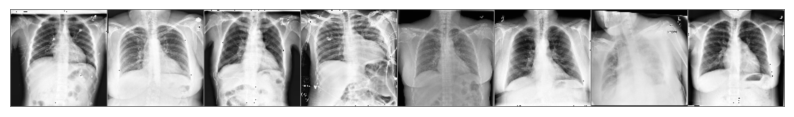

Labels: ['true', 'true', 'true', 'true', 'true', 'false', 'false', 'true']


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision


# Helper to unnormalize and display
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize [-1, 1] → [0, 1]
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images and labels
imshow(torchvision.utils.make_grid(images))
print("Labels:", [train_dataset.classes[label] for label in labels])

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)       # 3 number of input channels for a colored image   # 16 number of output channels (neurons)
        self.pool = nn.MaxPool2d(2, 2)      # reduces spatial size by half  # `2` is the kernel size (2x2 pixels) of the pooling operation. # `2` is the stride of the pooling operation.
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)     # 16 is the number of input channels which must be equal to the number of output channels in the previous layer.32 is the number of output channels (neurons). It is a hyperparameter.
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # assuming input image is 224x224 → becomes 28x28 after 3 times pooling
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 2)  # 2 classes: false, true

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # → 112x112
        x = self.pool(F.relu(self.conv2(x)))   # → 56x56
        x = self.pool(F.relu(self.conv3(x)))   # → 28x28
        x = x.view(-1, 64 * 28 * 28)           # flatten   # 64 channels (feature maps)  # size 28 × 28
                                               # The -1 tells PyTorch: “Automatically infer this dimension based on the other values and the total number of elements.” The -1 is automatically filled in as 8 if batch size is 8
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [11]:
import torch.optim as optim
import torch
from torch.utils.tensorboard import SummaryWriter


model = CNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# Initialize TensorBoard
writer = SummaryWriter('runs/cardiomegaly')

In [12]:
num_epochs = 3
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set model to training mode

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()           # Reset gradients
        outputs = model(inputs)         # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                 # Backpropagation
        optimizer.step()               # Update weights

        running_loss += loss.item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")


[Epoch 1, Batch 100] Loss: 0.693
[Epoch 1, Batch 200] Loss: 0.692
[Epoch 1, Batch 300] Loss: 0.683
[Epoch 1, Batch 400] Loss: 0.676
[Epoch 2, Batch 100] Loss: 0.671
[Epoch 2, Batch 200] Loss: 0.653
[Epoch 2, Batch 300] Loss: 0.619
[Epoch 2, Batch 400] Loss: 0.638
[Epoch 3, Batch 100] Loss: 0.642
[Epoch 3, Batch 200] Loss: 0.621
[Epoch 3, Batch 300] Loss: 0.632
[Epoch 3, Batch 400] Loss: 0.609
Finished Training


In [13]:
import matplotlib.pyplot as plt

num_epochs = 5
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)            # torch.max(outputs, 1) returns two values: 1- The maximum value (we ignore it using _) 2- The index of the maximum value → this is the predicted class
                                                        # predicted now holds the model’s predicted class for each image in the batch.
        total += labels.size(0)                         # labels.size(0) is the number of labels in the batch. We’re summing this into total to count how many samples we've seen so far.
        correct += (predicted == labels).sum().item()   # .item() converts the result from a tensor to a plain Python number

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Save stats for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

print("Finished Training")


[Epoch 1] Train Loss: 0.6024, Accuracy: 67.38% | Val Loss: 0.5958, Accuracy: 67.23%
[Epoch 2] Train Loss: 0.5795, Accuracy: 68.65% | Val Loss: 0.5747, Accuracy: 69.26%
[Epoch 3] Train Loss: 0.5702, Accuracy: 69.61% | Val Loss: 0.5590, Accuracy: 69.03%
[Epoch 4] Train Loss: 0.5568, Accuracy: 70.45% | Val Loss: 0.5584, Accuracy: 70.27%
[Epoch 5] Train Loss: 0.5386, Accuracy: 70.85% | Val Loss: 0.5534, Accuracy: 69.48%
Finished Training


accuracy and loss are improving on both train and validation sets. This is not overfitting yet — training and validation accuracy are improving together.
You might even benefit from more epochs.

#### Visualize Loss and Accuracy Curves

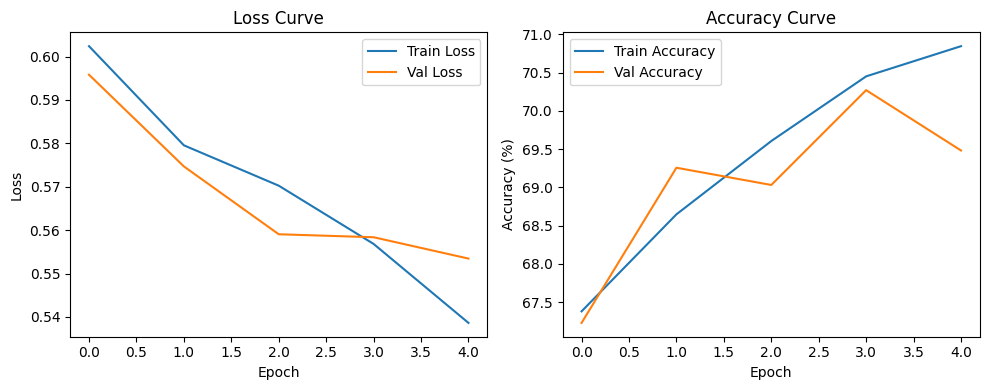

In [14]:
# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

num_epochs = 8
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)            # torch.max(outputs, 1) returns two values: 1- The maximum value (we ignore it using _) 2- The index of the maximum value → this is the predicted class
                                                        # predicted now holds the model’s predicted class for each image in the batch.
        total += labels.size(0)                         # labels.size(0) is the number of labels in the batch. We’re summing this into total to count how many samples we've seen so far.
        correct += (predicted == labels).sum().item()   # .item() converts the result from a tensor to a plain Python number

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Save stats for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

print("Finished Training")


[Epoch 1] Train Loss: 0.5269, Accuracy: 73.27% | Val Loss: 0.5614, Accuracy: 67.79%
[Epoch 2] Train Loss: 0.5129, Accuracy: 73.21% | Val Loss: 0.5652, Accuracy: 70.61%
[Epoch 3] Train Loss: 0.4848, Accuracy: 76.34% | Val Loss: 0.5444, Accuracy: 71.28%
[Epoch 4] Train Loss: 0.4665, Accuracy: 76.56% | Val Loss: 0.5563, Accuracy: 70.16%
[Epoch 5] Train Loss: 0.4264, Accuracy: 80.11% | Val Loss: 0.5764, Accuracy: 70.05%
[Epoch 6] Train Loss: 0.3943, Accuracy: 81.97% | Val Loss: 0.5735, Accuracy: 68.47%


In [ ]:
# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


Loss Curve:
Training loss keeps decreasing smoothly showing model is learning from the training set.

Validation loss initially decreased but now is increasing sharply after epoch 5.

Accuracy Curve Insight:
Training accuracy climbs from ~74% to nearly 90% showing very strong learning on train data.

Validation accuracy peaked around epoch 2–5 (~70%), then declined.

↓ Val Accuracy, ↑ Train Acc, ↑ Val Loss:	Model is memorizing train data and model is overfitting

# Training with Early Stopping

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

num_epochs = 8  # You can set this high; early stopping will stop it early

# Early stopping setup
patience = 3          # If validation loss hasn't improved for 3 epochs in a row, stop training.
best_val_loss = float('inf')      # float('inf') means positive infinity. The first actual validation loss will definitely be better and stored.
epochs_no_improve = 0             # how many epochs have passed **without validation improvement**. If this reaches the value of `patience`, we stop training.
early_stop = False                # optional
best_model_wts = copy.deepcopy(model.state_dict())      # Saves the **initial model weights** in case early stopping triggers later. Each time validation loss improves, this is **updated** with the new best weights.

# Tracking for visualization
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Save stats for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print progress
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_wts = copy.deepcopy(model.state_dict())  # Save best weights
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            early_stop = True
            break

# Restore best model
# model.load_state_dict(best_model_wts)
# print("Best model restored.")


In [ ]:
# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


1- What is a Convolutional Neural Network (CNN)? Describe its key components and how they differ from those in a fully connected neural network.

CNN is a type of Artificial Neural Network to extract features from grid-like data like images or videos.
key components are:
- Convolutional Layers: Applies kernel(filter) over the input image to detect patternslike edges and shapes
- Activation Function
- Pooling Layers
- Fully Connected (Dense) Layers
-